In [22]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bert_serving.client import BertClient
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt

client = BertClient(check_length=False)

# Introduction

The purpose of this project is to create a persona which has a technical personality. Our created persona should be able to differentiate the technical message from any other message topic on the based of interest scores. To achieve this, I first create a sample dictionary of approximately 50 words through which our input message would be compared. Before I discuss the logic I have used, it is important to list the techniques used. For vectorizing the plain texts to words, I have used a word embedding technique known as Bert. Word embedding is technique in NLP where words or phrases from the vocabulary are mapped to vectors of real numbers. Bidirectional Encoder Representations from Transformers (BERT) is a technique for NLP pre-training developed by Google. The main purpose for the creation of BERT by google was to understand user searches. BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task.

Once we are done with BERT embeddings, the result of finding word embeddings between 2 sentences(dictionary and our input message) is a vector. Once we have 2 vectors, we can calculate the similarity using the cosine similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.  
This project has just one function which has 4 subdivided steps which are as follows:

1) Preprocessing

2) Calculating Interest Scores

3) Calculating the lyft Scores

4) Visualizing positive and negative lyft scores

In [43]:
Dictionary = ['tech', 'gta 4', 'gta','gaming keyboard','pubg', 'fifa','technology', 'laptop', 'mouse', 'electronics', 'desktop', 'TV', 'television', 'Home Audio','apps','cloud','web','interface','innovation', 'machine learning','artificial intelligence','sensor','data science','data','charger','git','version','update' ,'phones','home theater', 'gadgets','IOT','computer science','Camera', 'photo', 'video', 'cell phone', 'mobile','headhopnes', 'games', 'video games', 'gaming','bluetooth', 'wireless','speakers','electronics','amazon','tablets','software','printers','drives', 'floppy', 'keyboard','apple','iphone','android','samsung', 'Computer Parts', 'age of empires']


# Steps and Logic

As we have dicussed earlier that the we have 4 subdivided steps in our function, let's look at them one by one. 

1) Preprocessing: Preprocessing in text data is required for transferring text from human language to machine-readable format for further processing. In my code, I have removed the stop words, punctuation, converted words from upper case to lower case, and tokenized the message

2) Calculating interest Scores: Once the preprocessing is done, we will be left with some filtered and clean words that we will use for further processing. Now, for each filtered word in our input message, we will vectorize with each word in the dictionary using the BERT word embedding technique and compute the cosine similarity. Now, for each word, we will have a different similary score with the each word in the dictionary. We will take the max score per word and then average the score for all words. This average is our interest score in the message. Through this logic, I will return an interest score. 

3) Calculating lift scores: To calculate the lift in scores, I will iteratively delete one word at a time. Say for example, if my filtered words had a count of 7, in the logic for lift, it will always have the count of 6 iteratively deleting each word and the left words will be the new filtered words. After that, the same logic will be used to calcuate the interest score and we will subtract the newly created interest score from the interest score calculated from the original message. Through this logic, I will return a dataframe of lift score corresponding to the words that were removed iteratively that lead to the new interest score and the lift. 

4) Visualizations: If the count of positive and negative list words from a message is greater than or equal to 3, I will be return a bar plot of both positive and negative words with the corrseponding lift scores.   

In [74]:
def persona(message):
    """
    This function takes as input a message, does the preprocessing steps,calculates its interest score with the 
    tech dictionary. After that in part 2, we calculate the lyft in interest score when we iteratively delete a message 
    from our input text. Finally, in part 3, we are creating visualizations of change in interest score for positives and 
    negatives seperately
    :param name: input message text
    :returns: 1) Interest score in the message
              2) Data frame of lyft in interest score corresponding to the removed word
              3) Positive and Negative word Bar plot if the count of both are greater than or equal to 3
    """
    ### preprocessing ###
    message = message.lower()                                       ##upper case to lower case
    message = word_tokenize(message)                                ##breaking the message into words 
    filtered_words = [word for word in message if word not in stopwords.words('english')]  ##removing stop words
    filtered_words = [c for c in filtered_words if c not in string.punctuation]            ##removing punctuations   
    ### preprocessing ###
    
    cos_word = []                                                   ##empty lift to append the cosine similarity 
    word_text = []                                                  ##empty lift to append the message word in loop
    word_dict = []                                                  ##empty lift to append the dictionary word in loop
    count = len(Dictionary)                                         ##len of words in dictionary to later append the word
    
    ##start of logic for baseline interest score
    for i in filtered_words:                                ##looping over filtered words i.e. words after preprocessing
        word = i                                                ## capturing the word from loop's iteration 
        word = list(word.split("-"))                    ##converting into a list as list type is required in BERT's encoing
        for j in Dictionary:                                     ##iterating over dictionary words
            reference = j                                       ##capturing the word  
            reference = list(reference.split("-"))              ##converting to list  
            sentences = client.encode([word, reference], show_tokens=False, is_tokenized=True) 
            ##using BERT word embedding to vectorize the word and corresponding dictionary word
            cos_word.append(cosine_similarity(sentences[0,:].reshape(1,-1),sentences[1,:].reshape(1,-1)))  
            ##calculating cosine similarity on the 2 vectors
            word_dict.append(j)                                 ##appending dictionary word to later create a dataframe
        for y in range(count):                  ##loop to append the message word count times. count = length of dictionary
            word_text.append(i)                                 ##append to a list count times
        
    df = pd.DataFrame({'word':word_text,'dictionary':word_dict,'Similarity':cos_word})  
    ##creating a dataframe of word, dictionary word and interest score 
    df['Similarity'] = df['Similarity'].astype('float')                 ##chaning the datatype of interest score to float 
    df = df.groupby(['word'])['Similarity'].max().reset_index() 
    ##finding the maximum interest score for each word wrt dictionary word
    interest = df["Similarity"].mean()                                  ##averaging interest scores of all words
    ##start of logic for lift scores
    word_lift = []  
    lift= []       
    for f in filtered_words:                                                        ##looping over filtered words 
        word_lift_text = []                                                         ##empty list for words
        dict_lift = []                                                              ##empty list for dictionary
        cos_lift = []                       ##emply list of interest score for new message deleted iteratively
        word_lift = f                                                               ##capturing filtered word
        word_lift = list(word_lift.split("-"))                                      ##converting to list
        filtered_words_runtime = filtered_words.copy()                              ##creating a copy for runtime 
        filtered_words_runtime.remove(f)                                            ##delete the word
        for x in filtered_words_runtime:                                            ##looping over new message
            word_1 = x                                                              ##capturing word
            word_1 = list(word_1.split("-"))                                        ##creating a list
            for d in Dictionary:                                                    ##looping over dictionary word
                reference_lift = d                                                  ##capturing dictionary word
                reference_lift = list(reference_lift.split("-"))                    ##creating list 
                sentences_lift = client.encode([word_1, reference_lift], show_tokens=False, is_tokenized=True) 
                ##using BERT word embedding to vectorize the word and corresponding dictionary word
                cos_lift.append(cosine_similarity(sentences_lift[0,:].reshape(1,-1),sentences_lift[1,:].reshape(1,-1))) 
                ##calculating cosine similarity from vectors
                dict_lift.append(d)                                                 ##capturing dictionary word
            for y in range(count):                                                  ##looping over count of dictionary word
                word_lift_text.append(x)                                            ##appending word text dictionary times 
        df1 = pd.DataFrame({'word':word_lift_text,'dictionary':dict_lift,'Similarity':cos_lift}) 
        ##creating a dataframe of word,dictionary word and correspondig score
        df1['Similarity'] = df1['Similarity'].astype('float')                       ##converting interest score to float
        df1 = df1.groupby(['word'])['Similarity'].max().reset_index()   
        ##finding maximum interest score for each word with respect to dictionary word
        
        lift.append(interest - df1["Similarity"].mean())                 
    ##averaging interest scores of all words and appending into a list after subtracting it with the baseline inerest score.
    df_final = pd.DataFrame({'word':filtered_words,'Lift':lift})        
    ##once the loop is over, getting a final df of removed words and interest score
    df_final_P = df_final[(df_final['Lift']>0)].sort_values('Lift')              ##dataframe for positive lift scores
    df_final_N = df_final[(df_final['Lift']<0)].sort_values('Lift')              ##dataframe for negative lift scores
    print('The interest score in this message is '+str(interest))                ##printing baseline interest scores
    
    ##visualizations to print if both positive and negative words are atleast 3
    if (len(df_final_P) >= 3) & (len(df_final_N) >= 3): 
        plt.barh(data = df_final_P, y = 'word', width= 'Lift', align = 'center', alpha = 0.7)
        plt.xlabel('Lyft Score')
        plt.ylabel('Word')
        plt.title('Positive lift scores by word')
        plt.show()
        plt.barh(data = df_final_N, y = 'word', width= 'Lift', align = 'center', alpha = 0.7)
        plt.xlabel('Lyft Score')
        plt.ylabel('Word')
        plt.title('Negative lift scores by word')
        plt.show()
    return df_final                                                      ##return final dataframe of words and lift scores

# Test Cases

The interest score in this message is 0.870554406195879


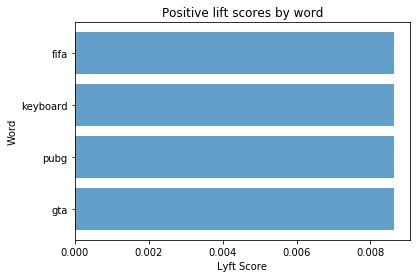

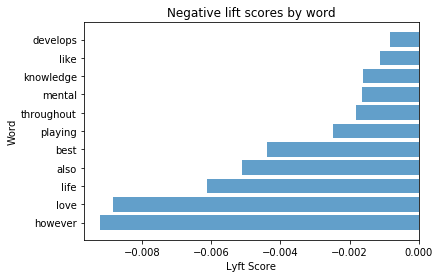

,word,Lift
0,playing,-0.002467
1,gta,0.008630
2,throughout,-0.001818
3,life,-0.006112
4,however,-0.009216
5,like,-0.001116
6,fifa,0.008630
7,love,-0.008835
8,pubg,0.008630
9,gaming,0.000000


In [68]:
persona("I have been playing GTA throughout my life, however, now I like fifa more. I love PUBG too. Gaming also develops your mental knowledge. I have the best gaming keyboard there is.")

From the above output, we can see that the message has a baseline interest score of 87%. This message is relevant to our tech persona and we can infer from the positive visualization plot that removing the words such as fifa, gta, pubg and keyboard reduced the interest score. One of reasons for this is that these words are included in our dictionary.

The interest score in this message is 0.8235321164131164


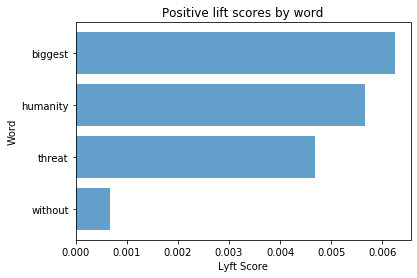

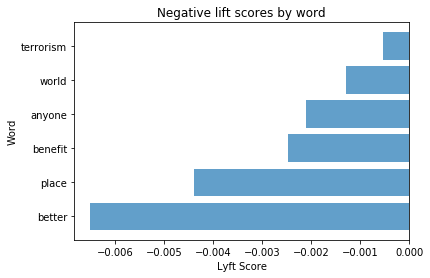

,word,Lift
0,world,-0.001282
1,better,-0.006499
2,place,-0.004384
3,without,0.000679
4,terrorism,-0.000537
5,benefit,-0.002471
6,anyone,-0.002092
7,biggest,0.006242
8,threat,0.004686
9,humanity,0.005658


In [67]:
persona("This world is a better place without terrorism as it does not benefit anyone and is the biggest threat to humanity")

From the above output, we can note that interest score is about 82% in the message. From the visualizations and the dataframe, we can see that the positive words such as biggest, humanity, threat and without are the important words as the interest score decreased when we removed them.

The interest score in this message is 0.8976999521255493


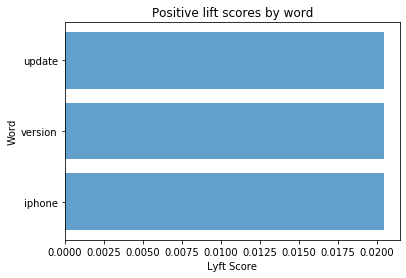

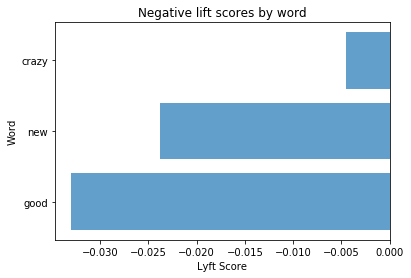

,word,Lift
0,new,-0.023805
1,update,0.020460
2,version,0.020460
3,iphone,0.020460
4,crazy,-0.004534
5,good,-0.033041


In [53]:
persona("The new update version of iphone is crazy good")

From the above output, we can see that the message has a baseline interest score of 89.7%. This message is relevant to our tech persona and we can infer from the positive visualization plot that removing the words such as update, version and iphone reduced the interest score. One of reasons for this is that these words are included in our dictionary.

The interest score in this message is 0.8863552113374075


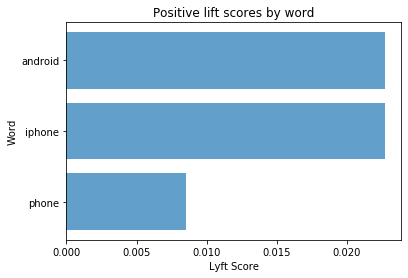

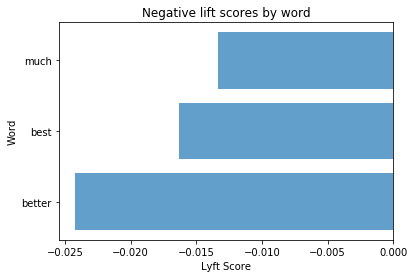

,word,Lift
0,iphone,0.022729
1,best,-0.016320
2,phone,0.008492
3,much,-0.013367
4,better,-0.024264
5,android,0.022729


In [54]:
persona("Iphone is the best phone and it is much better than android")

From the above output, we can see that the message has a baseline interest score of 88.6%. This message is relevant to our tech persona and we can infer from the positive visualization plot that removing the words such as android, phone and iphone reduced the interest score. One of reasons for this is that these words are included in our dictionary.

The interest score in this message is 0.784885436296463


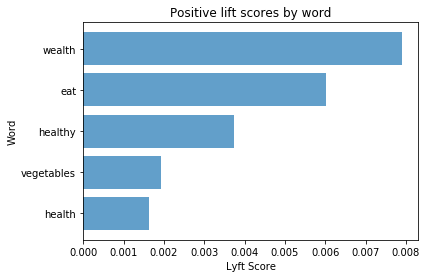

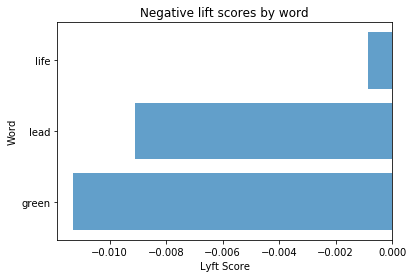

,word,Lift
0,health,0.001640
1,wealth,0.007903
2,eat,0.006018
3,green,-0.011290
4,vegetables,0.001939
5,lead,-0.009092
6,healthy,0.003740
7,life,-0.000858


In [69]:
persona("health is wealth. Eat green vegetables to lead a healthy life")

From the above output, we can note that interest score is about 78.4% in the message. From the visualizations and the dataframe, we can see that the positive words such as wealth, health, eat and vegetables are the important words as the interest score decreased when we removed them.

The interest score in this message is 0.7884999173028129


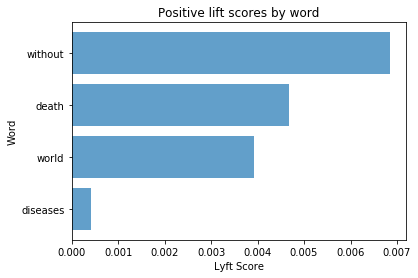

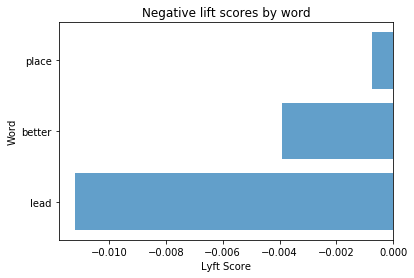

,word,Lift
0,world,0.003916
1,better,-0.003910
2,place,-0.000737
3,without,0.006858
4,diseases,0.000414
5,lead,-0.011210
6,death,0.004670


In [73]:
persona("This world is a better place without diseases that lead to death")

From the above output, we can note that interest score is about 78.8% in the message. From the visualizations and the dataframe, we can see that the positive words such as without, world, death and deseases are the important words as the interest score decreased when we removed them.

In [71]:
persona("I love playing gta and fifa")

The interest score in this message is 0.8928933888673782


,word,Lift
0,love,-0.051623
1,playing,-0.019781
2,gta,0.035702
3,fifa,0.035702


From the above output, we can note that the interest score is 89.2%. This message is relevent to our tech persona and this short message was just to text that the bar plot doesn't show up when the count of positive and negative words seperately is less than 3. 

# Conclusion

From the testing examples, I could conclude that with BERT word embeddings, I was able to get an interest score of 85% or higher when I would input a message related to my tech persona and when the message was not related the scores were in the range of 75% to 82%. It is known that BERT is not very good in predicting the semantics of different sentences and hence, the next steps would invlove trying different techniques.

# Next Steps

The next step would involve using different word embedding techniques such as word2vec, glove, fasttext, doc2vec, wordnet, etc. and compare which technique is better in distinguishing the input message based on the personality of our persona.